In [18]:
#!/usr/bin/env python
# coding: utf-8

from constraint import *
import numpy as np
import string, random
import copy
import time


###### Partie 1 : Prepare list_domaine
def readfile(file):
    lines=[]
    dic_file=dict()
    with open(file) as f:
        for line in f:
            #print(line.rstrip())
            word=list(line.rstrip())#.split('')
            lg_word=len(word)
            if lg_word in dic_file:
                dic_file[lg_word].append(word)
            else:
                dic_file[lg_word]=[word]
    return dic_file

def check_correct(instance, word):
    bien_place=0
    mal_place=0
    list_not_match1=[]
    list_not_match2=[]
    for i in range(len(instance)):
        if instance[i]==word[i]:
            bien_place+=1
        else:
            list_not_match1.append(instance[i])
            list_not_match2.append(word[i])
    for letter in list_not_match1:
        if letter in list_not_match2:
            list_not_match2.remove(letter)
            mal_place+=1
    return bien_place, mal_place

def dict_to_liste_solution(solution , n):
    l=[]
    for i in range(n):
        l.append(solution["x"+str(i)])
    return l

dictionnary=readfile('./dico.txt')
#print(dictionnary[4])

#assert((check_correct("tarte","dette"))==(2,1))
#assert((check_correct("bonjour","nobjour")==(5,2)))

def find_bien_place(solution, n, bien_place, list_index, word):
    for i in range(n):
        if i not in list_index:
            avant=solution[i]
            solution[i]="_"
            bien_place_new,_ =check_correct(solution, word)
            if bien_place_new<bien_place:
                solution[i]=avant
                return i
    print("Erreur : func_find_bien_place")

###### Partie 2 : algorithme genetique
# 
# evaluation_distance✅
# fitness [可能可以优化]
# selection ✅
# mutation_aleatoire✅
# mutation_echange ✅
# mutation_inverse ✅
# croisement ✅
# 
# 

def evaluation_distance(str1,str2):
    '''
        calcul distance d'edition 计算两个字符串间的需要编辑的距离
        fitness = 1 - mot non bien place/len(mot)  需要更改的字母数/总字母数
    '''
    n = str1.__len__()
    distance = np.zeros((n+1,n+1))

    for i in range(0,n+1):
        distance[i,0] = i
        distance[0,i] = i
    
    for i in range(1, n+1):
        for j in range(1,n+1):
            if str1[i-1] == str2[j-1]:
                cost = 0
            else:
                cost = 1
            distance[i,j] = min(distance[i-1,j]+1,distance[i,j-1]+1,distance[i-1,j-1]+cost)
    
    return distance[n,n]

def fitness(solution,word):
    return 1- evaluation_distance(solution,word)/len(word)

def mutation(solution,p_mutation_alea,p_mutation_echange,p_mutation_inverse):
    p = np.random.random()
    n = len(solution)
    #print('valuer p',p)
    new_solution = []
    if p<p_mutation_alea:
        #print('mutation  : alea')
        new_solution = aleatoire(solution)
    if p>p_mutation_alea and p<p_mutation_echange:
        #print('mutation  : echange')
        new_solution = echange(solution)
    if p>p_mutation_echange and p < p_mutation_inverse:
        #print('mutation  : inverse')
        new_solution = inverse(solution)
    else: 
        new_solution = solution
    return new_solution

def aleatoire(str):
    new_str = []
    n = len(str)
    #print('lenth',n)
    pos = random.randint(0,n-1)
    #print(pos)
    l = random.choice(string.ascii_lowercase)
    #print(l)
    #str[pos] = l 
    part_1 = list(str[0:pos])
    part_2 = list(str[pos+1:])
    new_str = part_1+list(l)+part_2
    new_str = ''.join(new_str)
    #print('new str =', new_str)
    return new_str

def echange(str):
    n = len(str)
    str = list(str)
    #print(n)
    pos1 = np.random.randint(0,n)
    pos2 = np.random.randint(0,n)
    pos1,pos2 = min(pos1,pos2),max(pos1,pos2)
    #print(pos1,pos2)
    str[pos1],str[pos2] = str[pos2],str[pos1]
    #new_str = str[0:pos1]+str[pos2]+str[pos1+1:pos2]+str[pos1]+str[pos2+1:]
    #print(new_str)
    new_str = ''.join(str)
    #print('new str =', new_str)
    return new_str

def inverse(str):
    str = list(str)
    #print(len(str))
    left = random.randint(0,len(str)-1)
    right = random.randint(left,len(str)-1)
    #print(left,right)
    while left < right:
        str[left], str[right] = str[right], str[left]
        left += 1
        right -= 1
    #print(str)
    new_str = ''.join(str)
    #print(new_str)
    return new_str


nb_selecte = 1

def selection(word,parents,nb = nb_selecte):
#或者用somme cumulee也可以
    l_fitness = {}
    select_value = []
    for i in range(len(parents)):
        l_fitness[parents[i]] = fitness(parents[i],word)
    #print('list fitness',l_fitness)
    value_list = []
    for key,value in l_fitness.items():
        v = int(value * 100)
        value_list += v*[key]
    #print('value_list',value_list)
    if value_list == []: 
        #print('null')
        value_list = parents
    for i in range(nb):
        select_value.append(random.choice(value_list))
    return select_value




def croisement_fonde(p1, p2, p=-1):
    p1,p2 = list(p1),list(p2)
    if p==-1:
        p=np.random.randint(len(p1))
    f1=p1[:p]
    p2_new=p2
    p2_new=[i for i in p2_new if i not in f1]
    f1=f1+p2_new
    f2=p2[:p]
    p1_new=p1
    p1_new=[i for i in p1_new if (i not in f2)]
    f2=f2+p1_new
    return f1,f2



# longeur : la longeur de mot secret 
# _mu : nombre de parent
# _lambda : nombre de fils
# population initiale

def algo_genetique(word,_mu,_lambda,p_mutation_alea=0.25,p_mutation_echange=0.5,p_mutation_inverse = 0.75):
    '''
    Etant donnée une population d'individus E avec fitness > 0
    il s'agit de prendre les '_mu' meilleurs avec une propabilite propotionnelle à fitness , puis de créer _lambda enfants. 
    Chaque enfant aura pour parent l'un des _mu parents (sélectionné propotionnelle a fitness).
    La population E à la génération suivante sera ajouter les enfants.
    '''
    nb_essais = 0
    start = time.time()
    runtime = 0
    parents = []
    longeur = len(word)
    list_mot=np.array(dictionnary[longeur])
    list_domain=[set(list_mot[:,i]) for i in range(longeur)]
    #for i in range(longeur):
    #    print(len(list_domain[i]))

    #for i in range(len(list_domain)):
        #print('len domain before ',len(list_domain[i]))
    # generate parents

    for j in range(_mu):
        p1 = [a for a in range(longeur)]
        for i in range(longeur):
            #print('variable ',i)
            p1[i] = random.sample(list_domain[i],1)    
            p1[i] = ''.join(p1[i])
        p2 = ''.join(p1)
        #print('p2',p2)
        #print('parents before while',parents)
        #print('tmp',tmp,'p1',p1)
        while fitness(p2,word) == 0 or p2 in parents:
            #print('while ')
            nb_essais += 1
            if fitness(p2,word) == 0 :
                #print('fitness 0',p2 )
                for i in range(longeur):
                    list_domain[i].remove(p1[i])
                    p1[i] = random.sample(list_domain[i],1)
                    p1[i] = ''.join(p1[i])
            elif(p2 in parents): 
                #print('p2 in parents',p2)
                for i in range(longeur):
                    p1[i] = random.sample(list_domain[i],1)
                    p1[i] = ''.join(p1[i])   
            p2 = ''.join(p1)
            #print('p1',p1)
            #print(p1 in parents)
        #print('---------p1',p1)
        p2 = p1
        p2 = ''.join(p2)
        #print('---------p2 jion',p2)
        tmp = copy.deepcopy(''.join(p1))
        parents.append(tmp)
        #print(parents)
        #print(list_domain)
        #for i in range(len(list_domain)):
            #print('list domain',len(list_domain[i]),list_domain[i])   

        if word in parents:
            print('trouve!')
            break
    print('--------------generation finish, parents: ',parents)
    #return parents,fitness

    #generate fils
    nb_generation = 0
    while (word not in parents) and (nb_generation < MAXGEN) and (runtime < MAXTIME) and (len(parents) < MAXSIZE):
    #for k in range(nb_generation):
        #print('-----------------generation',nb_generation)
        nb_generation += 1
        for i in range(_lambda):
            #print('iteration', i)
            select_p1 = selection(word,parents,1)
            #print('select p1',select_p1)
            select_p1 = ''.join(select_p1)
            #print('mutation p1',select_p1)
            select_p1 = mutation(select_p1,p_mutation_alea,p_mutation_echange,p_mutation_inverse)
            if (fitness(select_p1,word))==0:
                nb_essais += 1
                select_change = list(select_p1)
                for i in range(longeur):
                    if select_change[i] in list_domain[i]:
                        list_domain[i].remove(select_change[i])
                        select_change[i] = random.sample(list_domain[i],1)
                        select_change[i] = ''.join(select_p1[i])
            elif(select_p1 in parents):
                nb_essais += 1
                #print('select_change in parents',select_p1)
                select_change = list(select_p1)
                for i in range(longeur):
                    select_change[i] = random.sample(list_domain[i],1)
                    select_change[i] = ''.join(select_change[i])   
            else: 
                parents.append(select_p1)
            #print('new parents',parents)
        end = time.time()
        runtime = end - start
        print(runtime)


        #for i in range(len(list_domain)):
            #print('list domain',len(list_domain[i]),list_domain[i])   


    print('finale E length=',len(parents),'nb_generation=',nb_generation,'runtime=',runtime,'nombre essais=',nb_essais)
    #print('E est',set(parents))

    if word in parents: print('trouve!')
    if nb_generation >= MAXGEN: print('nombre generation > MAXGEN',MAXGEN)
    if runtime >= MAXTIME : print('runtime > MAXTIME',MAXTIME)
    if len(parents) >= MAXSIZE : print('E plus grand que MAXSIZE',MAXSIZE)

    #l_fitness = {}
    #for i in range(len(parents)):
    #    l_fitness[parents[i]] = fitness(parents[i],word)
    #print(l_fitness)
   
    return parents,nb_generation,runtime,nb_essais #,l_fitness

p_mutation_alea = 0.25
p_mutation_echange  = 0.5
p_mutation_inverse = 0.75
MAXSIZE = 500
MAXGEN = 100
MAXTIME = 180 #3 minutes

#E,gen,t,iter = algo_genetique('psiss',30,10)
test_list = 8
list_tt, list_iter = [],[]
iter,tt = [],[]
for longeur in range(2,9):
    print(longeur,'longeur')
    for i in range(10):
        list_mot = np.array(dictionnary[longeur])
        word = list_mot[np.random.randint(list_mot.shape[0])]
        word = ''.join(word)
        E,gen,t,iteration = algo_genetique(word,30,10)
        tt.append(t) 
        iter.append(iteration)
    list_tt.append(np.mean(tt))
    print(list_tt)
    list_iter.append(np.mean(iter))
    print(list_iter)


2 longeur
trouve!
--------------generation finish, parents:  ['rs', 'ss', 'uf', 'ut', 'uw', 'us']
finale E length= 6 nb_generation= 0 runtime= 0 nombre essais= 19
trouve!
trouve!
--------------generation finish, parents:  ['in', 'at', 'au', 'nn', 'an']
finale E length= 5 nb_generation= 0 runtime= 0 nombre essais= 16
trouve!
trouve!
--------------generation finish, parents:  ['ik', 'ot', 'oi', 'oo', 'oy', 'ok']
finale E length= 6 nb_generation= 0 runtime= 0 nombre essais= 17
trouve!
trouve!
--------------generation finish, parents:  ['um', 'im', 'pm', 'ew', 'wm', 'ed', 'em']
finale E length= 7 nb_generation= 0 runtime= 0 nombre essais= 15
trouve!
trouve!
--------------generation finish, parents:  ['id', 'ig', 'dn', 'io', 'ih', 'iw', 'in']
finale E length= 7 nb_generation= 0 runtime= 0 nombre essais= 17
trouve!
trouve!
--------------generation finish, parents:  ['mk', 'mp', 'mh', 'mo', 'me']
finale E length= 5 nb_generation= 0 runtime= 0 nombre essais= 17
trouve!
trouve!
--------------ge

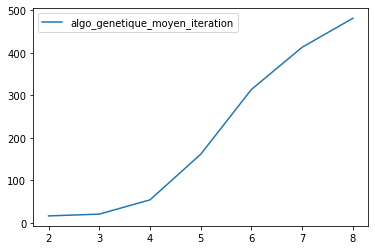

In [21]:
import matplotlib.pyplot as plt
n_range=[i for i in range(2,9)]
plt.plot(n_range,list_iter, label="algo_genetique_moyen_iteration")
plt.legend()
plt.show()

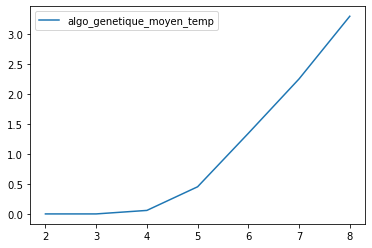

In [24]:
import matplotlib.pyplot as plt
n_range=[i for i in range(2,9)]
plt.plot(n_range,list_tt, label="algo_genetique_moyen_temp")
plt.legend()
plt.show()